In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import warnings


warnings.filterwarnings("ignore")

In [28]:
df = pd.read_csv('BTC-USD.csv', parse_dates=['Date'])
train = df.loc[df['Date'] < '2022-05-01',['Date','Close']].set_index('Date').sort_index()

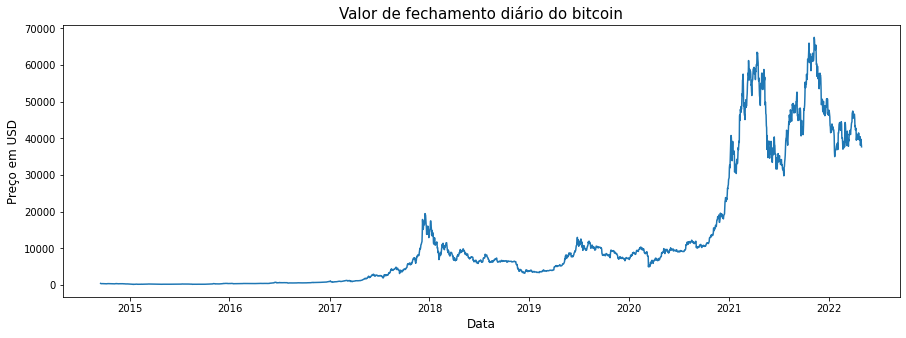

In [29]:
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(train)

plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço em USD', fontsize=12)
plt.title("Valor de fechamento diário do bitcoin", fontsize=15)

plt.show()

In [30]:

def test_stationarity(x):
   #Determing rolling statistics
   rolmean = x.rolling(window=22,center=False).mean()
   rolstd = x.rolling(window=12,center=False).std()
   
   #Plot rolling statistics:
   plt.plot(x, color='blue',label='Original')
   plt.plot(rolmean, color='red', label='Rolling Mean')
   plt.plot(rolstd, color='black', label = 'Rolling Std')
   plt.legend(loc='best')
   plt.title('Rolling Mean & Standard Deviation')
   plt.show(block=False)
   
   #Perform Dickey Fuller test    
   result=adfuller(x)

   print('ADF Stastistic: %f'%result[0])
   print('p-value: %f'%result[1])
   print("The graph is non stationery" if result[0]> result[4]['1%'] else "The graph is stationery")
   print('Critical values:')
   for key,value in result[4].items():
      print('\t%s: %.3f ' % (key, value))

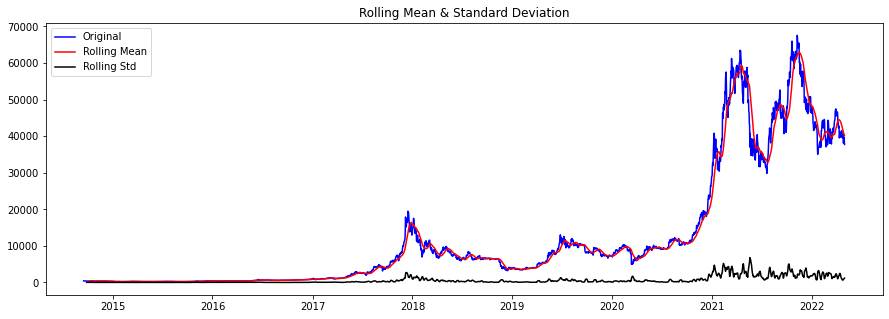

ADF Stastistic: -1.267099
p-value: 0.644087
The graph is non stationery
Critical values:
	1%: -3.433 
	5%: -2.863 
	10%: -2.567 


In [31]:
ts = train['Close']
test_stationarity(ts)

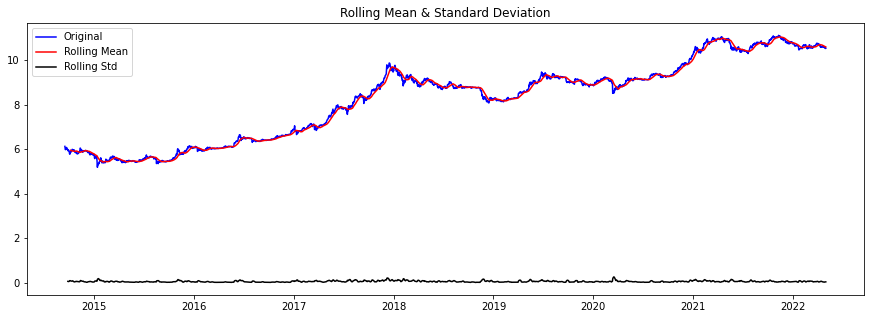

ADF Stastistic: -0.597045
p-value: 0.871648
The graph is non stationery
Critical values:
	1%: -3.433 
	5%: -2.863 
	10%: -2.567 


In [32]:
ts_log = np.log(ts)
test_stationarity(ts_log)

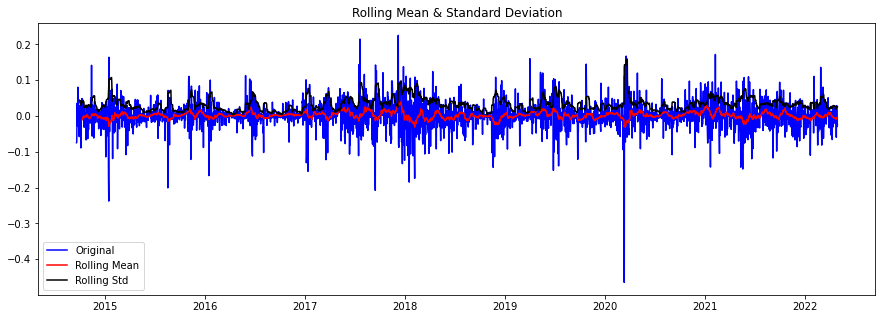

ADF Stastistic: -15.892515
p-value: 0.000000
The graph is stationery
Critical values:
	1%: -3.433 
	5%: -2.863 
	10%: -2.567 


In [33]:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

In [34]:
def plot_fitted(results, serie_diff):
    plt.plot(serie_diff)
    plt.plot(results.fittedvalues, color='yellow')
    rss = sum(
        (results.fittedvalues - serie_diff[1:])**2)
    print('RSS: %.7f' % rss)
    plt.title('RSS: %.7f' % rss)
    plt.show()

### AR

RSS: 6.3915342


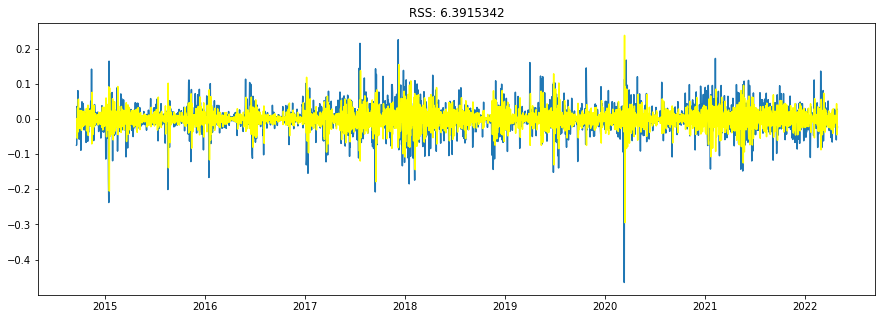

In [35]:
model = ARIMA(ts_log_diff, order=(1, 1, 0))
results_AR = model.fit(disp=-1)
plot_fitted(results_AR, ts_log_diff)

### MA

RSS: 8.2676857


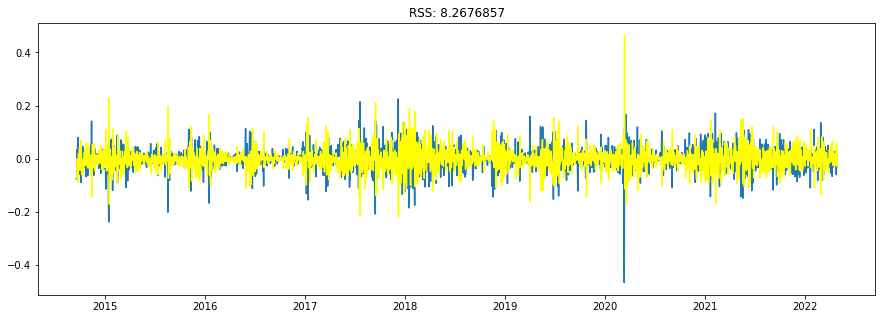

In [36]:
model = ARIMA(ts_log_diff, order=(0,1,1))
results_MA = model.fit(disp=-1)
plot_fitted(results_MA, ts_log_diff)

### ARIMA

RSS: 7.0887070


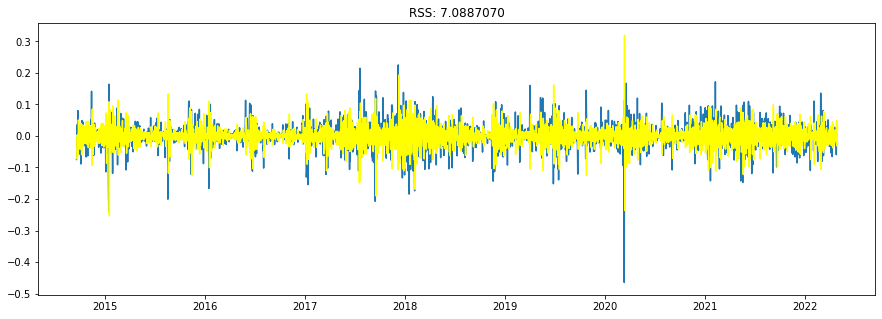

In [37]:
model = ARIMA(ts_log_diff, order=(2, 1, 0))
results_ARIMA = model.fit(disp=-1)
plot_fitted(results_ARIMA, ts_log_diff)

In [38]:
# # Divide into train and test
# def pred_value(t):
#     model = ARIMA(ts_log_diff, order=(1, 1, 0))
#     results_AR = model.fit(disp=-1)
#     print(results_AR.summary())
#     output = results_AR.forecast()
#     train_arima.append(t)
#     return float(np.exp(output[0]))

# size = int(len(ts_log) * 0.8)
# train_arima = ts_log_diff[:size].to_list()
# test_arima = ts_log_diff[size:]

# # Calculate the predictions
# results = pd.DataFrame({'test': test_arima.to_list()}, index=test_arima.index)
# results['original'] = np.exp(results['test'])
# results['prediction'] = results['test'].map(lambda t:pred_value(t))
# results['error'] = results['prediction'] - results['original']
# results['error_mean'] = (abs(results['prediction'] - results['original'])) * 100 / results['original']

# # Print the results values
# print(results)

# # Error. 
# print('MFE: %.2f' % (results['error'].mean()))
# print('MAE: %.2f' % (results['error'].abs().mean()))
# print('MAPE: %.3f' % (round(results['error_mean'].mean(),2)), '%')

# # Plot the results
# plt.figure(figsize=(15,5))
# plt.plot(results.index, results['original'], color = 'green')
# plt.plot(results.index, results['prediction'], color= 'orange')
# plt.title('Expected Vs Predicted Views Forecasting')
# plt.xlabel('Day')
# plt.ylabel('Closing Price')
# plt.legend({'Orginal','Predicted'})
# plt.show()

In [39]:
size = int(len(ts_log)-100)
# Divide into train and test
train_arima, test_arima = ts_log[0:size], ts_log[size:len(ts_log)]
history = list(train_arima)
predictions = []
originals = []
error_list = []

print('Printing Predicted vs Expected Values...')
print('\n')
# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):
    model = ARIMA(history, order=(2, 1, 0))
    model_fit = model.fit(disp=-1)

    output = model_fit.forecast()

    pred_value = output[0]


    original_value = test_arima[t]
    history.append(original_value)

    pred_value = np.exp(pred_value)


    original_value = np.exp(original_value)

    # Calculating the error
    error = ((abs(pred_value - original_value)) / original_value) * 100
    error_list.append(error)
    print('predicted = %f,   expected = %f,   error = %f ' % (pred_value, original_value, error), '%')

    predictions.append(float(pred_value))
    originals.append(float(original_value))

# After iterating over whole test set the overall mean error is calculated.   
print('\n Mean Error in Predicting Test Case Articles : %f ' % (sum(error_list)/float(len(error_list))), '%')
plt.figure(figsize=(8, 6))
test_day = list(range(len(test_arima)))
labels={'Orginal','Predicted'}
plt.plot(test_day, predictions, color= 'green')
plt.plot(test_day, originals, color = 'orange')
plt.title('Expected Vs Predicted Views Forecasting')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend(labels)
plt.show()

Printing Predicted vs Expected Values...




LinAlgError: Array must not contain infs or NaNs